In [1]:
import matplotlib.pyplot as plt
import numpy as np
import qutip as qt
import scipy

π = np.pi
µs_to_ns = 1e3

## 2 Capacitively Coupled Transmon Qubits (including f state energy level)

In [7]:
#states
num_qubit_states = 3

g_state = qt.basis(num_qubit_states, 0)
e_state = qt.basis(num_qubit_states, 1)
f_state = qt.basis(num_qubit_states, 2)

#operators
b1 = qt.tensor(qt.destroy(num_qubit_states), qt.qeye(num_qubit_states))
b1dag = b1.dag() 
b2 = qt.tensor(qt.qeye(num_qubit_states), qt.destroy(num_qubit_states))
b2dag = b2.dag() 

gg_proj = qt.tensor(g_state, g_state).proj()
ge_proj = qt.tensor(g_state, e_state).proj()
gf_proj = qt.tensor(g_state, f_state).proj()

eg_proj = qt.tensor(e_state, g_state).proj()
ee_proj = qt.tensor(e_state, e_state).proj()
ef_proj = qt.tensor(e_state, f_state).proj()

fg_proj = qt.tensor(f_state, g_state).proj()
fe_proj = qt.tensor(f_state, e_state).proj()
ff_proj = qt.tensor(f_state, f_state).proj()

## Hamiltonian (included counter rotating terms)
$H/\hbar = \sum_{i=1}^2{\left(\omega_i b_i^\dagger b_i + \frac{\alpha_i}{2} b_i^\dagger b_i^\dagger b_i b_i\right)} + J(b_1^\dagger b_2+b_2^\dagger b_1+b_1^\dagger b_2^\dagger+b_1 b_2)$

In [9]:
def hamiltonian(omega_1, omega_2, alpha_1, alpha_2, J_coupling):
    t1 = (omega_1 * b1dag * b1) + (omega_2 * b2dag * b2)
    t2 = (alpha_1 / 2 * b1dag * b1dag * b1 * b1) + (alpha_2 / 2 * b2dag * b2dag * b2 * b2)
    t4 = J_coupling * (b1dag * b2 + b2dag * b1)
    t5 = J_coupling * (b1dag * b2dag + b1 * b2)
    return t1 + t2 + t5 +t4

def nocounter(omega_1, omega_2, alpha_1, alpha_2, J_coupling):
    t1 = (omega_1 * b1dag * b1) + (omega_2 * b2dag * b2)
    t2 = (alpha_1 / 2 * b1dag * b1dag * b1 * b1) + (alpha_2 / 2 * b2dag * b2dag * b2 * b2)
    t4 = J_coupling * (b1dag * b2 + b2dag * b1)
    return t1 + t2 + t4

### Gate Times Investigation

0.7861711930858316 0.7861711930858316 0.7853981633974483
0.499225299301686 0.49922042809871503 0.5
339 339


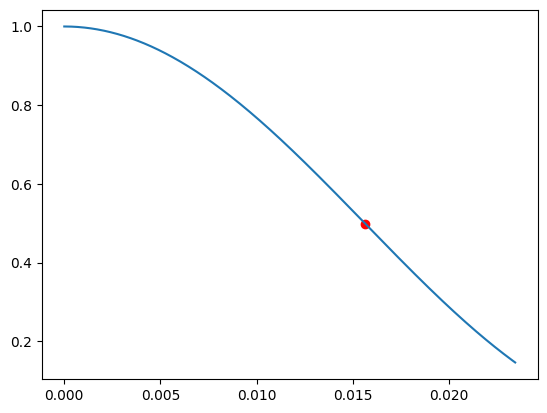

In [10]:
def calc_gatetime(t_vec, omega1, omega2, alpha, J_coupling, hamiltonian, plotbool):
    h = hamiltonian(omega_1=omega1, omega_2=omega2, alpha_1=alpha, alpha_2=alpha, J_coupling=J_coupling)
    psi0 = qt.tensor(e_state, g_state) #start in eg state
    te = qt.mesolve(h, psi0, t_vec, [], []) #time evolve with t_vec
    eg_pops = qt.expect(eg_proj, te.states)
    argmin = np.argmin(np.abs(eg_pops-0.5)[1:]) + 1 #argument of value closest to 0.5
    if plotbool == True:
        fig = plt.figure()
        plt.plot(t_vec, eg_pops) #blue line
        plt.scatter(t_vec[argmin], eg_pops[argmin], c='r') #red dot 
    return eg_pops[argmin], t_vec[argmin], argmin

J_coupling = 2*π * 8
t_start = 0
t_end = 6 * π/(4*J_coupling) #π/4J ~ reach maximally entangled state (Jt = π/4)
t_vec = np.linspace(t_start, t_end/4, 509)
omega1 = 2*π * 6000
omega2 = 2*π * 6000
alpha = 2*π * -300

pop, gatetime, arg = calc_gatetime(t_vec, omega1, omega2, alpha, J_coupling, hamiltonian, True)
pop_no, gatetime_no, arg_no = calc_gatetime(t_vec, omega1, omega2, alpha, J_coupling, nocounter, False)

#note in 2010 Nature Paper Bialczak SQiSW: g/2 = J, gt = π/2, Jt = π/4
print(J_coupling * gatetime, J_coupling * gatetime_no, π/4)
print(pop, pop_no, 0.5)
print(arg, arg_no)

#### Takeaways: 
- population number for with or without counter rotating terms are different (good), whereas gatetimes are identical
- with specific time vector, minization function locates gatetime for both hamiltonians that is identical to the analytical gatetime
- varied time vectors can lead to minimazation function landing on differing gatetimes between w/, w/o, theoretical gatetimes 

## Sanity Check, are mesolve / qt.propogator / theoretical SQiSW unitary in agreement
1. Start: 4 initial wave functions <br>
2. Evolve until full population is recovered using: i: mesolve, ii: propogator, iii: unitary <br>
3. Compare final states via fidelity measurement (should all be 1)

In [11]:
_, gatetime, _ = calc_gatetime(t_vec, omega1, omega2, alpha, J_coupling, hamiltonian, False)
h = hamiltonian(omega_1=omega1, omega_2=omega2, alpha_1=alpha, alpha_2=alpha, J_coupling=J_coupling)
sanity_t_vec = np.linspace(t_start, 4*gatetime, 601) #time vector to recover all of initial population (4*SQiSW time)

psi0 = qt.Qobj(np.array(qt.tensor(g_state, g_state)))
psi1 = qt.Qobj(np.array(qt.tensor(g_state, e_state)))
psi2 = qt.Qobj(np.array(qt.tensor(e_state, g_state)))
psi3 = qt.Qobj(np.array(qt.tensor(e_state, e_state)))

def compute_propogator(h, t_vec): #output propogator matrix
    propogator = qt.propagator(h, t_vec)
    prop = qt.Qobj(np.array(propogator[-1]))
    return prop

def compute_unitary(phi_1, phi_2, phi_3): #output theoretical unitary evolution matrix
    return qt.Qobj(np.array(
        qt.tensor(g_state, g_state).proj() * 1
        + qt.tensor(e_state, g_state).proj() * np.exp(1j*phi_1)
        + qt.tensor(g_state, e_state).proj() * np.exp(1j*phi_2)
        + qt.tensor(f_state, g_state).proj() * 1
        + qt.tensor(e_state, e_state).proj() * np.exp(1j*phi_3)
        + qt.tensor(g_state, f_state).proj() * 1
        + qt.tensor(f_state, e_state).proj() * 1
        + qt.tensor(e_state, f_state).proj() * 1
        + qt.tensor(f_state, f_state).proj() * 1
    ))

def sesolve_evolution(psi0, psi1, psi2, psi3, h): #output final states
    te0 = qt.mesolve(h, psi0, sanity_t_vec, [], [])
    te1 = qt.mesolve(h, psi1, sanity_t_vec, [], [])
    te2 = qt.mesolve(h, psi2, sanity_t_vec, [], [])
    te3 = qt.mesolve(h, psi3, sanity_t_vec, [], [])
    return te0.states[-1], te1.states[-1], te2.states[-1], te3.states[-1]  

sanityprop = compute_propogator(h, sanity_t_vec)
sanitytunit = compute_unitary(π/4, π/4, π)
s0, s1, s2, s3 = sesolve_evolution(psi0, psi1, psi2, psi3, h)

print(qt.fidelity(s0, sanityprop * psi0))
print(qt.fidelity(s1, sanityprop * psi1))
print(qt.fidelity(s2, sanityprop * psi2))
print(qt.fidelity(s3, sanityprop * psi3))
print(qt.fidelity(s0, sanitytunit * psi0))
print(qt.fidelity(s1, sanitytunit * psi1))
print(qt.fidelity(s2, sanitytunit * psi2))
print(qt.fidelity(s3, sanitytunit * psi3))

0.9999999917941078
0.9999999829723749
0.9999999829723752
0.9999999824892357
0.9999997572348015
0.9999935316233698
0.9999935316233699
0.9991605492548539


note: fidelities of |11> initial state evolution most greatly deviates from 1 ==> Swap + CZ shared interaction
##### ____ _______End of Sanity Check_______ ____

# SQiSW Simulation
## Goal: estimate fidelities

### 1: Via Propogator-- compare unitary operators

In [26]:
_, gatetime, _ = calc_gatetime(t_vec, omega1, omega2, alpha, J_coupling, hamiltonian, False)
h = hamiltonian(omega_1=omega1, omega_2=omega2, alpha_1=alpha, alpha_2=alpha, J_coupling=J_coupling)
newt_vec = np.linspace(t_start, gatetime, 601)
propogator = compute_propogator(h, newt_vec)
propogator

Quantum object: dims = [[9], [9]], shape = (9, 9), type = oper, isherm = False
Qobj data =
[[ 9.99999277e-01+5.24534145e-04j  0.00000000e+00+0.00000000e+00j
  -3.28575337e-05+2.03046840e-05j  0.00000000e+00+0.00000000e+00j
  -8.80304925e-04+6.28965258e-04j  0.00000000e+00+0.00000000e+00j
  -3.28575337e-05+2.03046840e-05j  0.00000000e+00+0.00000000e+00j
   1.28616699e-06-9.15029556e-07j]
 [ 0.00000000e+00+0.00000000e+00j  3.86441513e-01+5.91513529e-01j
   0.00000000e+00+0.00000000e+00j  5.92430336e-01-3.87040638e-01j
   0.00000000e+00+0.00000000e+00j -3.79125033e-04-5.79970066e-04j
   0.00000000e+00+0.00000000e+00j  2.51415391e-04-1.15644706e-04j
   0.00000000e+00+0.00000000e+00j]
 [-3.28276401e-05+2.02862110e-05j  0.00000000e+00+0.00000000e+00j
   9.93301272e-01+9.01394143e-02j  0.00000000e+00+0.00000000e+00j
  -4.93064587e-02+3.05896500e-02j  0.00000000e+00+0.00000000e+00j
  -5.57688350e-03+4.27848056e-02j  0.00000000e+00+0.00000000e+00j
   7.38825063e-05-4.59965858e-05j]
 [ 0.0000000

In [27]:
(propogator * psi0) - te0.states[-1]

Quantum object: dims = [[9], [1]], shape = (9, 1), type = ket
Qobj data =
[[ 0.00000000e+00+0.00000000e+00j]
 [-3.26532917e-05-5.02751367e-05j]
 [ 0.00000000e+00+0.00000000e+00j]
 [ 5.11557372e-05-3.35969824e-05j]
 [ 0.00000000e+00+0.00000000e+00j]
 [-9.54107086e-06+2.50488245e-05j]
 [ 0.00000000e+00+0.00000000e+00j]
 [-4.92114923e-08+1.87328751e-07j]
 [ 0.00000000e+00+0.00000000e+00j]]

### SQiSW Theoretical Matrix

In [28]:
SQiSW_matrix = np.array([[1, 0, 0, 0],
                         [0, (1/np.sqrt(2)), (1/np.sqrt(2))*(1j), 0],
                         [0, (1/np.sqrt(2))*(1j), (1/np.sqrt(2)), 0],
                         [0, 0, 0, 1]], dtype=complex)
SQiSW = qt.Qobj(SQiSW_matrix)
SQiSW

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[1.        +0.j         0.        +0.j         0.        +0.j
  0.        +0.j        ]
 [0.        +0.j         0.70710678+0.j         0.        +0.70710678j
  0.        +0.j        ]
 [0.        +0.j         0.        +0.70710678j 0.70710678+0.j
  0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.        +0.j
  1.        +0.j        ]]

In [29]:
SQiSW_9x9_matrix = np.array([[1, 0, 0, 0, 0, 0, 0, 0, 0],
                         [0, (1/np.sqrt(2))*(1), 0, (1/np.sqrt(2))*(1j), 0, 0, 0, 0, 0],
                         [0, 0, 0, 0, 0, 0, 0, 0, 0],
                         [0, (1/np.sqrt(2))*(1j), 0, (1/np.sqrt(2))*(1), 0, 0, 0, 0, 0],
                         [0, 0, 0, 0, 1, 0, 0, 0, 0],
                         [0, 0, 0, 0, 0, 0, 0, 0, 0],
                         [0, 0, 0, 0, 0, 0, 0, 0, 0],
                         [0, 0, 0, 0, 0, 0, 0, 0, 0],
                         [0, 0, 0, 0, 0, 0, 0, 0, 0],], dtype=complex)
T = qt.Qobj(SQiSW_9x9_matrix)
T

Quantum object: dims = [[9], [9]], shape = (9, 9), type = oper, isherm = False
Qobj data =
[[1.        +0.j         0.        +0.j         0.        +0.j
  0.        +0.j         0.        +0.j         0.        +0.j
  0.        +0.j         0.        +0.j         0.        +0.j        ]
 [0.        +0.j         0.70710678+0.j         0.        +0.j
  0.        +0.70710678j 0.        +0.j         0.        +0.j
  0.        +0.j         0.        +0.j         0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.        +0.j
  0.        +0.j         0.        +0.j         0.        +0.j
  0.        +0.j         0.        +0.j         0.        +0.j        ]
 [0.        +0.j         0.        +0.70710678j 0.        +0.j
  0.70710678+0.j         0.        +0.j         0.        +0.j
  0.        +0.j         0.        +0.j         0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.        +0.j
  0.        +0.j         1.        +0.j         0.    

Thought process- propogator function in the computational basis includes population evolution in higher energy levels, these should not ultimately be a part of the comparison. At the end of the day, we are operating in qubit computational basis, not qutrits.. if this is the assumption then f state evolution should not even be a part of the conversation

Write the SQiSW theoretical operation in the computational basis while including row and column 3 of 0's in order to keep the basis ordering in my simulation. -- it is not immediately clear to me how I can change the basis choice ordering for my simulation as I'm multiplying individual 3 dimensional hilbert spaces... Compare these two 5x5 matrices, obviously the f state evolution will continue to affect the nominal fidelity-- I can investigate the magnitude of this impact

In [30]:
qt.process_fidelity(propogator, T)

(0.162993537142209+0.08600339212558425j)

In [31]:
qt.process_fidelity(qt.Qobj(T[0:5, 0:5]), qt.Qobj(propogator[0:5, 0:5]))

(0.2726077525712537+0.06641243806451902j)

In [32]:
qt.Qobj(propogator[0:5, 0:5])

Quantum object: dims = [[5], [5]], shape = (5, 5), type = oper, isherm = False
Qobj data =
[[ 9.99999277e-01+5.24534145e-04j  0.00000000e+00+0.00000000e+00j
  -3.28575337e-05+2.03046840e-05j  0.00000000e+00+0.00000000e+00j
  -8.80304925e-04+6.28965258e-04j]
 [ 0.00000000e+00+0.00000000e+00j  3.86441513e-01+5.91513529e-01j
   0.00000000e+00+0.00000000e+00j  5.92430336e-01-3.87040638e-01j
   0.00000000e+00+0.00000000e+00j]
 [-3.28276401e-05+2.02862110e-05j  0.00000000e+00+0.00000000e+00j
   9.93301272e-01+9.01394143e-02j  0.00000000e+00+0.00000000e+00j
  -4.93064587e-02+3.05896500e-02j]
 [ 0.00000000e+00+0.00000000e+00j  5.92430336e-01-3.87040638e-01j
   0.00000000e+00+0.00000000e+00j  3.86441513e-01+5.91513529e-01j
   0.00000000e+00+0.00000000e+00j]
 [-8.79369043e-04+6.28296584e-04j  0.00000000e+00+0.00000000e+00j
  -4.92988911e-02+3.05849551e-02j  0.00000000e+00+0.00000000e+00j
  -3.19484389e-01+9.44028706e-01j]]

In [33]:
qt.Qobj(T[0:5, 0:5])

Quantum object: dims = [[5], [5]], shape = (5, 5), type = oper, isherm = False
Qobj data =
[[1.        +0.j         0.        +0.j         0.        +0.j
  0.        +0.j         0.        +0.j        ]
 [0.        +0.j         0.70710678+0.j         0.        +0.j
  0.        +0.70710678j 0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.        +0.j
  0.        +0.j         0.        +0.j        ]
 [0.        +0.j         0.        +0.70710678j 0.        +0.j
  0.70710678+0.j         0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.        +0.j
  0.        +0.j         1.        +0.j        ]]

### 2: Via State Evolution-- compare final states

In [36]:
def calculatephase(psi, te):
    initial_state = psi
    final_state = te.states[-1]
    initial_phase = np.angle(psi.dag()*initial_state)[0][0]
    final_phase = np.angle(psi.dag()*final_state)[0][0]
    total_phase = final_phase - initial_phase
    return total_phase

In [37]:
_, gatetime, _ = calc_gatetime(t_vec, omega1, omega2, alpha, J_coupling, hamiltonian, False)
h = hamiltonian(omega_1=omega1, omega_2=omega2, alpha_1=alpha, alpha_2=alpha, J_coupling=J_coupling)
newt_vec = np.linspace(t_start, gatetime, 601)

psi0 = qt.tensor(g_state, g_state)
psi1 = qt.tensor(e_state, g_state)
psi2 = qt.tensor(g_state, e_state)
psi3 = qt.tensor(e_state, e_state)

te0 = qt.mesolve(h, psi0, newt_vec, [], [])
te1 = qt.mesolve(h, psi1, newt_vec, [], [])
te2 = qt.mesolve(h, psi2, newt_vec, [], [])
te3 = qt.mesolve(h, psi3, newt_vec, [], [])

expstate0 = qt.Qobj([te0.states[-1][0][0], te0.states[-1][1][0], te0.states[-1][3][0], te0.states[-1][4][0]])
theostate0 = SQiSW * qt.Qobj(np.array([1, 0, 0, 0]))
print(qt.fidelity(expstate0, theostate0))

expstate1 = qt.Qobj([te1.states[-1][0][0], te1.states[-1][1][0], te1.states[-1][3][0], te1.states[-1][4][0]])
theostate1 = SQiSW * qt.Qobj(np.array([0, 1, 0, 0]))
print(qt.fidelity(expstate1, theostate1))

expstate2 = qt.Qobj([te2.states[-1][0][0], te2.states[-1][1][0], te2.states[-1][3][0], te2.states[-1][4][0]])
theostate2 = SQiSW * qt.Qobj(np.array([0, 0, 1, 0]))
print(qt.fidelity(expstate2, theostate2))

expstate3 = qt.Qobj([te3.states[-1][0][0], te3.states[-1][1][0], te3.states[-1][3][0], te3.states[-1][4][0]])
theostate3 = SQiSW * qt.Qobj(np.array([0, 0, 0, 1]))
print(qt.fidelity(expstate3, theostate3))

expstate1

0.9999994038666674
0.9999994227683956
0.9999994227683956
0.9966249074652874


Quantum object: dims = [[4], [1]], shape = (4, 1), type = ket
Qobj data =
[[0.        +0.j        ]
 [0.59246299-0.38699036j]
 [0.38639036+0.59154713j]
 [0.        +0.j        ]]

In [38]:
_, gatetime, _ = calc_gatetime(t_vec, omega1, omega2, alpha, J_coupling, hamiltonian, False)
h = hamiltonian(omega_1=omega1, omega_2=omega2, alpha_1=alpha, alpha_2=alpha, J_coupling=J_coupling)
newt_vec = np.linspace(t_start, gatetime, 601)
psi0 = qt.Qobj(np.array(qt.tensor(e_state, g_state)))
te0 = qt.mesolve(h, psi0, newt_vec, [], [])
te0.states[-1]

Quantum object: dims = [[9], [1]], shape = (9, 1), type = ket
Qobj data =
[[ 0.00000000e+00+0.00000000e+00j]
 [ 5.92462989e-01-3.86990363e-01j]
 [ 0.00000000e+00+0.00000000e+00j]
 [ 3.86390357e-01+5.91547126e-01j]
 [ 0.00000000e+00+0.00000000e+00j]
 [ 2.58005609e-04-1.39336213e-04j]
 [ 0.00000000e+00+0.00000000e+00j]
 [-3.74626047e-04-5.73350309e-04j]
 [ 0.00000000e+00+0.00000000e+00j]]

Reminder of 3 Level Basis Choice

In [26]:
psi0 = qt.tensor(g_state, g_state)   gg, ge, eg, ee  #theoretical
psi1 = qt.tensor(g_state, e_state)   gg, ge, gf, eg, ee, ef, fg, fe, ff #actual
psi2 = qt.tensor(g_state, f_state)
psi3 = qt.tensor(e_state, g_state)
psi4 = qt.tensor(e_state, e_state)
psi5 = qt.tensor(e_state, f_state)
psi6 = qt.tensor(f_state, g_state)
psi7 = qt.tensor(f_state, e_state)
psi8 = qt.tensor(f_state, f_state)


print(psi0[0], psi1[1], psi2[2], psi3[3], psi4[4], psi5[5], 
      psi6[6], psi7[7], psi8[8])

[[1.+0.j]] [[1.+0.j]] [[1.+0.j]] [[1.+0.j]] [[1.+0.j]] [[1.+0.j]] [[1.+0.j]] [[1.+0.j]] [[1.+0.j]]
